# Facial Expression Recognition using Convolutional Neural Networks

In [2]:
import torch
import numpy as np
import torch.nn.functional as F

from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Module

import torch.optim as optim
from torch.utils.data import DataLoader

import os
import pandas as pd

### Importing the data

In [3]:
path = 'data/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

In [4]:
data = pd.read_csv(path+'icml_face_data.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
import matplotlib.pyplot as plt

def plot_all_emotions(train_images, emotions, train_labels):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
data[' Usage'].value_counts()


 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [9]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
print(train_image_label)

[0 0 2 ... 4 0 4]


In [12]:
print(len(train_image_label))

28709


In [17]:
def one_hot_ecnoding(labels):
    labels_one_hot_encoded = np.zeros((len(labels), 7))
    for i, label in enumerate(labels):
        labels_one_hot_encoded[i, label] = 1
    return labels_one_hot_encoded

In [18]:
print(val_image_label.shape)

(3589,)


In [19]:
train_labels = one_hot_ecnoding(train_image_label)
val_labels = one_hot_ecnoding(val_image_label)
test_labels = one_hot_ecnoding(test_image_label)

In [20]:
from torch.utils.data import TensorDataset, DataLoader


tensor_train_x = torch.Tensor(train_images).permute(0, 3, 1, 2)
tensor_train_y = torch.Tensor(train_labels)

train_set = TensorDataset(tensor_train_x, tensor_train_y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                           shuffle=True, num_workers=4)


tensor_val_x = torch.Tensor(val_images).permute(0, 3, 1, 2)
tensor_val_y = torch.Tensor(val_labels)

print(tensor_val_x.shape)
print(tensor_val_y.shape)

val_set = TensorDataset(tensor_val_x, tensor_val_y)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4,
                                           shuffle=True, num_workers=4)

tensor_test_x = torch.Tensor(test_images).permute(0, 3, 1, 2)
tensor_test_y = torch.Tensor(test_labels)

test_set = TensorDataset(tensor_test_x, tensor_test_y)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                           shuffle=True, num_workers=4)


torch.Size([3589, 1, 48, 48])
torch.Size([3589, 7])


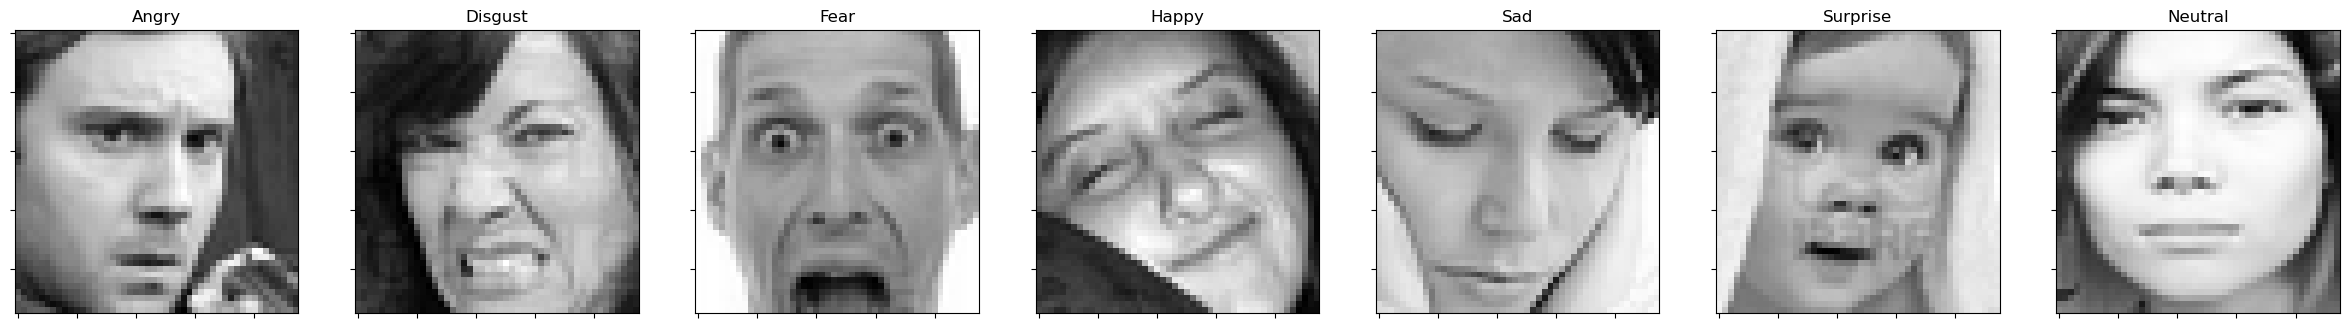

In [21]:
plot_all_emotions(train_images, emotions, train_labels)

## Inception v_1

The basic Inception block:

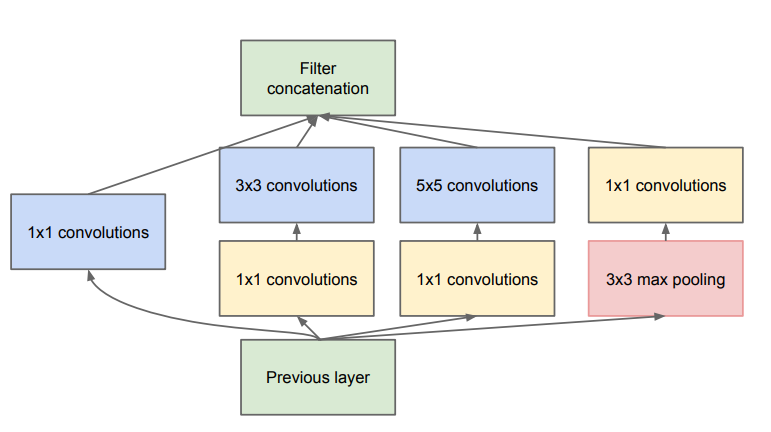


\[2] - Szegedy, Christian, et al. Going Deeper with Convolutions. arXiv:1409.4842, arXiv, 16 septembrie 2014. arXiv.org, https://doi.org/10.48550/arXiv.1409.4842.


In [22]:
class ConvolutionBlock(nn.Module):
    """
    Layer consisting of conv->batchnorm->relu

    """
    def __init__(self, in_channels , out_channels , kernel_size , stride , padding , activation='relu', norm='batch'):
        super(ConvolutionBlock,self).__init__()

        # 2d convolution
        self.conv2d = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding , bias=False )

        # batchnorm
        if norm == 'batch':
            self.batchnorm2d = nn.BatchNorm2d(out_channels)

        if activation == 'relu':
        # relu layer
            self.activation = nn.ReLU()

    def forward(self,x):
        x = self.conv2d(x)
        if self.batchnorm2d is not None:
            x = self.batchnorm2d(x)
        
        return self.activation(x)

In [23]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\soca274177\\Downloads\\graphviz-9.0.0-win32\\Graphviz\\bin'

torch.Size([32, 256, 28, 28])



(dot.exe:19612): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:29816): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


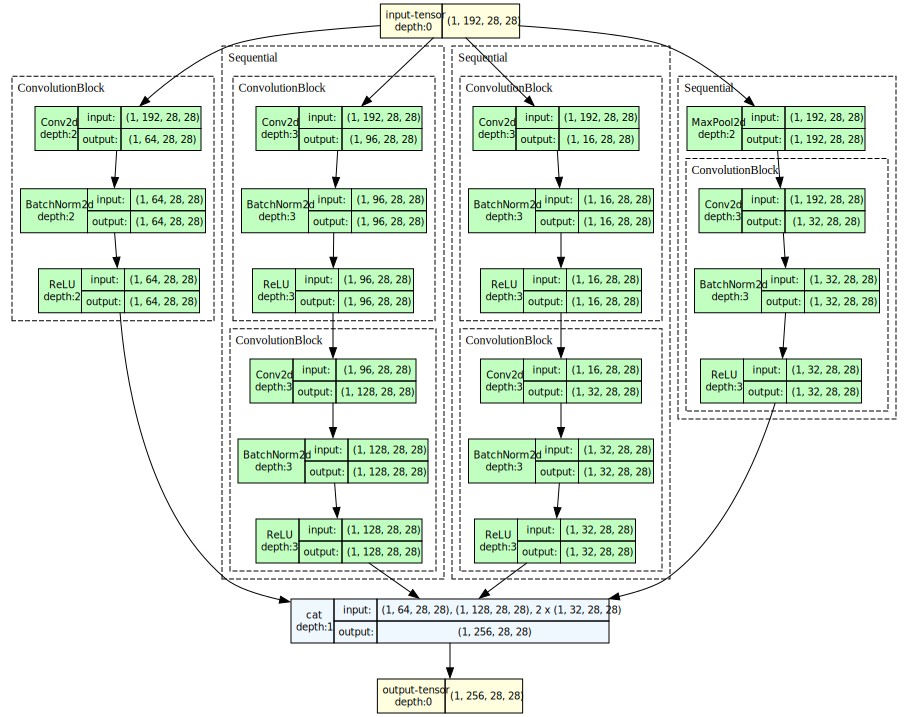

In [24]:
from torchview import draw_graph

class InceptionBlock(nn.Module):
    '''

    building block of inception-v1 architecture. creates following 4 branches and concatenate them
    (a) branch1: 1x1 conv
    (b) branch2: 1x1 conv followed by 3x3 conv
    (c) branch3: 1x1 conv followed by 5x5 conv
    (d) branch4: Maxpool2d followed by 1x1 conv

        Note:
            1. output and input feature map height and width should remain the same. Only the channel output should change. eg. 28x28x192 -> 28x28x256
            2. To generate same height and width of output feature map as the input feature map, following should be padding for
                * 1x1 conv : p=0
                * 3x3 conv : p=1
                * 5x5 conv : p=2


    Args:
       in_channels (int) : # of input channels
       out_1x1 (int) : number of output channels for branch 1
       red_3x3 (int) : reduced 3x3 referring to output channels of 1x1 conv just before 3x3 in branch2
       out_3x3 (int) : number of output channels for branch 2
       red_5x5 (int) : reduced 5x5 referring to output channels of 1x1 conv just before 5x5 in branch3
       out_5x5 (int) : number of output channels for branch 3
       out_1x1_pooling (int) : number of output channels for branch 4

    Attributes:
        concatenated feature maps from all 4 branches constituiting output of Inception module.

    '''
    def __init__(self , in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling):
        super(InceptionBlock,self).__init__()

        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvolutionBlock(in_channels,out_1x1,1,1,0)

        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = nn.Sequential(ConvolutionBlock(in_channels,red_3x3,1,1,0),ConvolutionBlock(red_3x3,out_3x3,3,1,1))

        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = nn.Sequential(ConvolutionBlock(in_channels,red_5x5,1,1,0),ConvolutionBlock(red_5x5,out_5x5,5,1,2))

        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3,stride=1,padding=1),ConvolutionBlock(in_channels,out_1x1_pooling,1,1,0))


    def forward(self,x):

        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)


def testInceptionBlock():
    x = torch.randn((32,192,28,28))
    model = InceptionBlock(192,64,96,128,16,32,32)
    print(model(x).shape)
    return model

model = testInceptionBlock()

architecture = 'InceptionBlock'
model_graph = draw_graph(model, input_size=(1,192,28,28), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph


In [172]:
# class IIPBlock(nn.Module):
#     def __init__(self, channe):
#         super(IIPBlock,self).__init__()


class InceptionNetwork(nn.Module):
    def __init__(self , in_channels = 1, num_classes = 7, reps = 3):
        super(InceptionNetwork,self).__init__()

        self.conv1 =  ConvolutionBlock(in_channels,64,3,1,1)
        self.conv2 =  ConvolutionBlock(64,128,3,1,1)
        
        # in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling
        self.inception1 = InceptionBlock(128, 32, 48, 64, 8, 16, 16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.iip_blocks = []

        self.iip_blocks.append(InceptionBlock(128, 32, 48, 64, 8, 16, 16))
        self.iip_blocks.append(InceptionBlock(128, 64, 96, 128, 16, 32, 32))
        self.iip_blocks.append(nn.MaxPool2d(kernel_size=2,stride=2,padding=1))

        self.iip_blocks.append(InceptionBlock(256, 64, 96, 128, 16, 32, 32))
        self.iip_blocks.append(InceptionBlock(256, 128, 192, 256, 32, 64, 64))
        self.iip_blocks.append(nn.MaxPool2d(kernel_size=2,stride=2,padding=1))

        self.iip_blocks.append(InceptionBlock(512, 128, 192, 256, 32, 64, 64))
        self.iip_blocks.append(InceptionBlock(512, 128, 192, 256, 32, 64, 64))
        self.iip_blocks.append(nn.MaxPool2d(kernel_size=4,stride=4,padding=1))

        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear( 2048 , num_classes)

    def forward(self,x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception1(x)

        x = self.maxpool1(x)

        for layer in self.iip_blocks:
            x = layer(x)
        
        x = self.dropout(x)

        flattened = x.view(4, -1)
        # print(flattened.shape)
        x = self.fc1(flattened)
        return x
 

In [173]:
def testInceptionBlock():
    x = torch.randn((4,1,48,48))
    model = InceptionNetwork()
    print(model(x).shape)
    return model

testInceptionBlock()

torch.Size([4, 7])


InceptionNetwork(
  (conv1): ConvolutionBlock(
    (conv2d): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv2): ConvolutionBlock(
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (inception1): InceptionBlock(
    (branch1): ConvolutionBlock(
      (conv2d): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (branch2): Sequential(
      (0): ConvolutionBlock(
        (conv2d): Conv2d(128, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batchnorm2d): BatchNorm2d(48, eps=1e-05, momentum=0.1, affi

# Training

In [174]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [33]:
device =  torch.device('cpu')

In [176]:
train_images.shape

(28709, 48, 48, 1)

In [177]:
train_labels.shape

(28709, 7)

In [190]:
model = InceptionNetwork()

In [179]:
print(sum(p.numel() for p in model.parameters()))

133559


In [181]:
print(tensor_train_x.shape)

torch.Size([28709, 1, 48, 48])


In [191]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200



In [183]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        if inputs.shape[0] != 4:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        # print(inputs.shape)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)

        total += len(outputs)
        correct += torch.sum(predicted == torch.argmax(targets, dim=1))

        if batch_idx % 100 == 0:
            print('Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
                 % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))

    print('Results after epoch %d' % (epoch + 1))

    print('Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))

Training Loss: 2.087 | Training Acc: 0.000% (0/4)
Training Loss: 2.899 | Training Acc: 15.594% (63/404)
Training Loss: 2.855 | Training Acc: 15.050% (121/804)
Training Loss: 2.873 | Training Acc: 15.947% (192/1204)
Training Loss: 2.890 | Training Acc: 16.085% (258/1604)
Training Loss: 2.928 | Training Acc: 16.717% (335/2004)
Training Loss: 2.910 | Training Acc: 16.972% (408/2404)
Training Loss: 2.943 | Training Acc: 17.297% (485/2804)
Training Loss: 2.971 | Training Acc: 17.541% (562/3204)
Training Loss: 2.984 | Training Acc: 17.786% (641/3604)
Training Loss: 2.991 | Training Acc: 17.682% (708/4004)
Training Loss: 3.015 | Training Acc: 17.802% (784/4404)
Training Loss: 3.005 | Training Acc: 18.027% (866/4804)
Training Loss: 3.028 | Training Acc: 17.948% (934/5204)
Training Loss: 3.049 | Training Acc: 17.827% (999/5604)
Training Loss: 3.045 | Training Acc: 17.871% (1073/6004)
Training Loss: 3.035 | Training Acc: 17.801% (1140/6404)
Training Loss: 3.041 | Training Acc: 17.828% (1213/6804

KeyboardInterrupt: 

## After reference 2

\[2] - Mollahosseini, Ali, et al. „Going Deeper in Facial Expression Recognition using Deep Neural Networks”. 2016 IEEE Winter Conference on Applications of Computer Vision (WACV), 2016, pp. 1–10. arXiv.org, https://doi.org/10.1109/WACV.2016.7477450.

In [25]:
class InceptionNetwork(nn.Module):
    def __init__(self , in_channels = 1, num_classes = 7, reps = 3):
        super(InceptionNetwork,self).__init__()

        self.conv1 =  ConvolutionBlock(in_channels,64,7,2,1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=0)

        self.conv2 =  ConvolutionBlock(64,192,3,1,1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3,stride=2,padding=0)
        
        # in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        # self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)


        self.maxpool3 = nn.MaxPool2d(kernel_size=3,stride=2,padding=0)
        self.inception4a = InceptionBlock(256, 192, 96, 208, 16, 48, 64)

        self.avgPool = nn.AvgPool2d(kernel_size=3,stride=2,padding=0)
        self.fc1 = nn.Linear( 480 , 4096)
        self.fc2 = nn.Linear( 4096 , 1024)
        self.fc3 = nn.Linear( 1024 , 7)


    def forward(self,x):

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.avgPool(x)

        flattened = x.view(4, -1)
        x = self.fc1(flattened)
        x = self.fc2(x)
        x = self.fc3(x)

        return x
 

In [28]:
def testInceptionBlock():
    x = torch.randn((4,1,48,48))
    model = InceptionNetwork()
    return model

In [29]:
testInceptionBlock()

InceptionNetwork(
  (conv1): ConvolutionBlock(
    (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvolutionBlock(
    (conv2d): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm2d): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvolutionBlock(
      (conv2d): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (branch2): Sequential(

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [43]:
model = InceptionNetwork()
model = model.to(device=device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10 

In [44]:
def evaluate():
    model.eval()

    valid_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(val_loader):

        
        if inputs.shape[0] != 4:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        valid_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total += len(outputs)
        correct += torch.sum(predicted == torch.argmax(targets, dim=1))

    print('  >>> Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)'
        % (valid_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
    
    return valid_loss / (batch_idx + 1), 100. * float(correct) / total

In [45]:
from torch.optim.lr_scheduler import PolynomialLR

scheduler = PolynomialLR(optimizer=optimizer, total_iters=10, power=0.5)

In [46]:
train_losses = []
train_acc = []
valid_loss = []
valid_acc = []

print(">>> Training starting...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        if inputs.shape[0] != 4:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        # print(inputs.shape)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)

        total += len(outputs)
        correct += torch.sum(predicted == torch.argmax(targets, dim=1))

        if batch_idx % 2000 == 0:
            print('Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
                 % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
            train_losses.append(train_loss / (batch_idx + 1))
            train_acc.append(100. * float(correct) / total)

    print('>>> Results after epoch %d' % (epoch + 1))

    print('  >>> Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
   
    val_loss, val_acc = evaluate()
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

    scheduler.step()
   

>>> Training starting...
Training Loss: 1.923 | Training Acc: 25.000% (1/4)
Training Loss: 1.810 | Training Acc: 26.374% (2111/8004)
Training Loss: 1.733 | Training Acc: 29.786% (4767/16004)
Training Loss: 1.679 | Training Acc: 32.365% (7769/24004)
>>> Results after epoch 1
  >>> Training Loss: 1.650 | Training Acc: 33.593% (9644/28708)
  >>> Validation Loss: 1.474 | Validation Acc: 40.803% (1464/3588)
Training Loss: 2.285 | Training Acc: 0.000% (0/4)
Training Loss: 1.455 | Training Acc: 42.591% (3409/8004)
Training Loss: 1.438 | Training Acc: 43.127% (6902/16004)
Training Loss: 1.428 | Training Acc: 43.651% (10478/24004)
>>> Results after epoch 2
  >>> Training Loss: 1.418 | Training Acc: 44.151% (12675/28708)
  >>> Validation Loss: 1.334 | Validation Acc: 50.056% (1796/3588)
Training Loss: 0.760 | Training Acc: 75.000% (3/4)
Training Loss: 1.311 | Training Acc: 48.226% (3860/8004)
Training Loss: 1.300 | Training Acc: 49.175% (7870/16004)
Training Loss: 1.299 | Training Acc: 49.663% (

## Second impl

In [84]:
class InceptionNetwork(nn.Module):
    def __init__(self , in_channels = 1, num_classes = 7, reps = 3):
        super(InceptionNetwork,self).__init__()

        self.conv1 =  ConvolutionBlock(in_channels,64,7,2,3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.conv2 =  ConvolutionBlock(64,192,3,1,1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        # in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        # self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)


        self.maxpool3 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)

        self.avgPool = nn.AvgPool2d(kernel_size=3,stride=1,padding=0)
        self.fc1 = nn.Linear( 512 , 4096)
        self.fc2 = nn.Linear( 4096 , 1024)
        self.fc3 = nn.Linear( 1024 , 7)


    def forward(self,x):

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)

        x = self.inception3b(x)

        x = self.maxpool3(x)
        x = self.inception4a(x)
        
        x = self.avgPool(x)

        flattened = x.view(4, -1)
        x = self.fc1(flattened)
        x = self.fc2(x)
        x = self.fc3(x)

        return x
 
 
def testInceptionBlock():
    x = torch.randn((4,1,48,48))
    model = InceptionNetwork()
    rez = model(x)
    return model

In [85]:
testInceptionBlock()

InceptionNetwork(
  (conv1): ConvolutionBlock(
    (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvolutionBlock(
    (conv2d): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm2d): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvolutionBlock(
      (conv2d): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (branch2): Sequential(

In [89]:
model = InceptionNetwork()
model = model.to(device=device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

In [90]:
from torch.optim.lr_scheduler import PolynomialLR

scheduler = PolynomialLR(optimizer=optimizer, total_iters=20, power=0.5)

In [91]:
train_losses = []
train_acc = []
valid_loss = []
valid_acc = []

print(">>> Training starting...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        if inputs.shape[0] != 4:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        # print(inputs.shape)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)

        total += len(outputs)
        correct += torch.sum(predicted == torch.argmax(targets, dim=1))

        if batch_idx % 2000 == 0:
            print('Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
                 % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
            train_losses.append(train_loss / (batch_idx + 1))
            train_acc.append(100. * float(correct) / total)

    print('>>> Results after epoch %d' % (epoch + 1))

    print('  >>> Training Loss: %.3f | Training Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
   
    val_loss, val_acc = evaluate()
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

    scheduler.step()
   

>>> Training starting...
Training Loss: 1.927 | Training Acc: 25.000% (1/4)
Training Loss: 1.957 | Training Acc: 21.402% (1713/8004)
Training Loss: 1.878 | Training Acc: 23.532% (3766/16004)
Training Loss: 1.822 | Training Acc: 25.996% (6240/24004)
>>> Results after epoch 1
  >>> Training Loss: 1.792 | Training Acc: 27.142% (7792/28708)
  >>> Validation Loss: 1.549 | Validation Acc: 37.570% (1348/3588)
Training Loss: 1.450 | Training Acc: 25.000% (1/4)
Training Loss: 1.564 | Training Acc: 36.994% (2961/8004)
Training Loss: 1.538 | Training Acc: 37.853% (6058/16004)
Training Loss: 1.511 | Training Acc: 39.210% (9412/24004)
>>> Results after epoch 2
  >>> Training Loss: 1.494 | Training Acc: 40.100% (11512/28708)
  >>> Validation Loss: 1.417 | Validation Acc: 44.816% (1608/3588)
Training Loss: 1.450 | Training Acc: 50.000% (2/4)
Training Loss: 1.391 | Training Acc: 45.877% (3672/8004)
Training Loss: 1.366 | Training Acc: 46.851% (7498/16004)
Training Loss: 1.346 | Training Acc: 47.492% (

KeyboardInterrupt: 

117 m

In [92]:
def test_model():
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):

        
        if inputs.shape[0] != 4:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        test_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total += len(outputs)
        correct += torch.sum(predicted == torch.argmax(targets, dim=1))

    print('  >>> Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)'
        % (test_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))
    
    return test_loss / (batch_idx + 1), 100. * float(correct) / total

In [93]:
test_model()

  >>> Validation Loss: 2.296 | Validation Acc: 60.535% (2172/3588)


(2.295506303324972, 60.53511705685619)